<a href="https://colab.research.google.com/github/jobellet/vlPFC_Visual_Geometry/blob/main/richness_of_vlPFC_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Richness of visual representations in the vlPFC
-----------------------------------------------------------------------------
#### This notebook replicates the analysis measuring the presence of perceptual dimensions in the early and late visual responses the vlPFC
----
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.
----

In [ ]:
private_link = input('Enter the private link token:')


# Analysis

In [2]:

import warnings
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from matplotlib import colors as mcolors
from PIL import Image
import cv2
import time
import re
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
import glob

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True

# Determine the path to the repository based on the environment
if IN_COLAB:
    path_to_repo = '/content/vlPFC_Visual_Geometry'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/vlPFC_Visual_Geometry'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/vlPFC_Visual_Geometry.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils')) # Add the utils directory to sys.path

from utils.extract_and_download_data import download_files, unzip
from utils.analysis_utils import (get_upper_indices, pairwise_euclidean_distance,
                                  spearman_corr_ranked, training_kind, round_robin_pairs,
                                  pairs_to_batches, perm_signflip_onesample, perm_diff_independent, condensed,
                                  rank_data, rank_jaccard_rdm, jaccard_distance, robust_rdm, rank_data_batch, zscore) # Added missing imports for analysis
from utils.plotting_utils import q_to_stars

# -------------------------------------------------------------------
# Analysis Script
# -------------------------------------------------------------------

print("Analysis Script start")

# Global parameters
N_PERM        = 10000
PERM_CHUNK    = 500
N_BATCH_RANK  = 200
BATCHES_HIVAR = 8
RNG = np.random.default_rng(42)

FIGURES_DIR   = Path("Figures")
STATISTICS_DIR = Path("Statistics")
DATA_FNAME    = STATISTICS_DIR / "rsa_results.npz"

# -------------------------------------------------------------------
# Download required data files once
files_to_download = [
    "Spike_count_even_sessions.npy",
    "Spike_count_odd_sessions.npy",
    "hvm_public_extended_meta.csv",
    "deepNetFeatures_landscape.zip"
]
# Pass the correct path to file_code_mapping.csv to download_files
download_files(path_to_repo, files_to_download, private_link=private_link)
# -------------------------------------------------------------------
# Load spike counts & metadata
print("Loading spike counts & metadata …")
spike_counts_even = np.load("downloads/Spike_count_even_sessions.npy",
                            allow_pickle=True)
spike_counts_odd  = np.load("downloads/Spike_count_odd_sessions.npy",
                            allow_pickle=True)
spike_counts = (spike_counts_even + spike_counts_odd) / 2.0
meta         = pd.read_csv("downloads/hvm_public_extended_meta.csv")

EARLY_SLICE = slice(5, 9)    # 50–90 ms
LATE_SLICE  = slice(10, 20)  # 100–200 ms
slices = [EARLY_SLICE, LATE_SLICE]

# -------------------------------------------------------------------
# A) Category structure in high-variation subset
print("Section A – High-variation category …")
hv_idx    = np.where(meta["rxz"] != 0)[0]
cat_codes = meta["category_name"].astype("category").cat.codes.to_numpy()
obs_hv, perm_hv = np.zeros(2), np.zeros((N_PERM, 2))

for split in np.array_split(hv_idx, BATCHES_HIVAR):
    X  = spike_counts[split]
    for w, sl in enumerate(slices):
        neu   = X[:, :, sl].reshape(len(split), -1)
        r_neu = rank_data(pdist(neu, "euclidean"))
        r_cat = rank_jaccard_rdm(jaccard_distance(cat_codes[split]))
        obs_hv[w] += spearman_corr_ranked(r_neu, r_cat)

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            sz    = p_end - p_start
            perms = np.stack([
                rank_jaccard_rdm(jaccard_distance(
                    RNG.permutation(cat_codes[split])))
                for _ in range(sz)
            ], axis=1)
            Y = perms - perms.mean(axis=0)
            perm_hv[p_start:p_end, w] += (Xc[:, None] * Y).sum(0) / dc / \
                                         np.sqrt((Y**2).sum(0))
obs_hv  /= BATCHES_HIVAR
perm_hv /= BATCHES_HIVAR

# -------------------------------------------------------------------
# B) Category-wise object structure
print("Section B – Category-wise object structure …")
CATS       = meta["category_name"].unique()
obs_sub    = np.zeros(2)
perm_sub   = np.zeros((N_PERM, 2))

for cat in CATS:
    idx = np.where(meta["category_name"] == cat)[0]
    X   = spike_counts[idx]
    for w, sl in enumerate(slices):
        neu   = X[:, :, sl].reshape(len(idx), -1)
        r_neu = rank_data(pdist(neu, "euclidean"))
        lbl   = meta.loc[idx, "object_name"].to_numpy()
        r_lbl = rank_jaccard_rdm(jaccard_distance(lbl))
        obs_sub[w] += spearman_corr_ranked(r_neu, r_lbl)

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            sz    = p_end - p_start
            perms = np.stack([
                rank_jaccard_rdm(jaccard_distance(RNG.permutation(lbl)))
                for _ in range(sz)
            ], axis=1)
            Y = perms - perms.mean(axis=0)
            perm_sub[p_start:p_end, w] += (Xc[:, None] * Y).sum(0) / dc / \
                                          np.sqrt((Y**2).sum(0))
obs_sub  /= len(CATS)
perm_sub /= len(CATS)

# -------------------------------------------------------------------
# C) Face feature models
print("Section C – Face feature models …")
face_idx = np.where((meta["rxz"] != 0) &
                    (meta["category_name"] == "Faces"))[0]
faces    = meta.loc[face_idx]

orient    = faces[["rxy_semantic","rxz_semantic","ryz_semantic"]].to_numpy(float)
size_feat = faces["s"].to_numpy(float)[:, None]
pos       = faces[["centroid_y","centroid_x"]].to_numpy(float)
pos       = (pos - 128.0) / 256.0 * 8.0
ang       = np.arctan2(pos[:,1], pos[:,0])
pos_vec   = np.c_[np.cos(ang), np.sin(ang)]

obs_face  = {k: np.zeros(2)       for k in ["orient","size","pos"]}
perm_face = {k: np.zeros((N_PERM,2)) for k in ["orient","size","pos"]}

for key, feat in [("orient", orient), ("size", size_feat), ("pos", pos_vec)]:
    for w, sl in enumerate(slices):
        neu   = spike_counts[face_idx, :, sl].reshape(len(face_idx), -1)
        r_neu = rank_data(pdist(neu, "euclidean"))
        dist  = "cosine" if key == "orient" else "euclidean"
        r_feat = rank_data(pdist(feat, dist)) if key == "orient" else \
                 rank_data(pdist(feat, dist))
        obs_face[key][w] = spearman_corr_ranked(r_neu, r_feat)

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            sz    = p_end - p_start
            perms = np.stack([
                rank_data(pdist(feat[RNG.permutation(len(feat))], dist))
                for _ in range(sz)
            ], axis=1)
            Y = perms - perms.mean(0)
            perm_face[key][p_start:p_end, w] += (Xc[:, None] * Y).sum(0) / dc / \
                                               np.sqrt((Y**2).sum(0))
# -------------------------------------------------------------------
# D) In-paint RSA
print("Section D – In-paint RSA …")
unzip("downloads/deepNetFeatures_landscape.zip",
      "deepNetFeatures_landscape")

def load_all(mode):
    paths = sorted(
        glob.glob(f"deepNetFeatures_landscape/*CLIP*features_{mode}.pkl"))
    feats, names = [], []
    for pkl in paths:
        with open(pkl, "rb") as f:
            d = pickle.load(f)
        feats.append(d["penultimate"].reshape(d["penultimate"].shape[0], -1))
        names.append(pd.Index(d["image_names"]))
    common = names[0]
    for nm in names[1:]:
        common = common.intersection(nm)
    common = common.sort_values()
    idxs   = [nm.get_indexer(common) for nm in names]
    return common, [f[i] for f, i in zip(feats, idxs)]

common, feats_list = load_all("inpainted_images_original")
idx_c      = pd.Index(meta["image_id"].str.strip()).get_indexer(common)
sc_inpaint = spike_counts[idx_c]
meta_in    = meta.set_index("image_id").loc[common].reset_index()

results = {}
for key, sl in zip(["Early","Late"], slices):
    neural = sc_inpaint[:, :, sl].reshape(sc_inpaint.shape[0], -1)
    obs, perm = [], []
    for obj in meta_in["object_name"].unique():
        idx_o = np.where(meta_in["object_name"] == obj)[0]
        if len(idx_o) < 3:
            continue
        r_neu = rank_data(pdist(neural[idx_o], "euclidean"))
        r_inp = robust_rdm([f[idx_o] for f in feats_list])
        obs.append(spearman_corr_ranked(r_neu, r_inp))

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        perm_vals = np.zeros((len(r_neu), N_PERM))
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            for j in range(p_start, p_end):
                perm_idx = RNG.permutation(len(idx_o))
                perm_vals[:, j] = rank_data(
                    pdist(neural[idx_o][perm_idx], "euclidean"))
        perm_ranked = rank_data_batch(perm_vals, N_BATCH_RANK)
        perm.append([spearman_corr_ranked(perm_ranked[:, j], r_inp)
                     for j in range(N_PERM)])
    results[key] = {"obs": np.mean(obs),
                    "null": np.mean(np.vstack(perm), axis=0)}

# -------------------------------------------------------------------
# Save everything
STATISTICS_DIR.mkdir(exist_ok=True)
np.savez_compressed(
    DATA_FNAME,
    category_obs=obs_hv,          category_perm=perm_hv,
    subcategory_obs=obs_sub,      subcategory_perm=perm_sub,
    face_orient_obs=obs_face['orient'],
    face_orient_perm=perm_face['orient'],
    face_size_obs=obs_face['size'], face_size_perm=perm_face['size'],
    face_pos_obs=obs_face['pos'],  face_pos_perm=perm_face['pos'],
    inpaint_obs=np.array([results['Early']['obs'],
                          results['Late']['obs']]),
    inpaint_perm=np.column_stack([results['Early']['null'],
                                  results['Late']['null']])
)
print("Analysis complete – results saved.")


Analysis Script start
Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/deepNetFeatures_landscape.zip.
Successfully downloaded downloads/Spike_count_even_sessions.npy.
Successfully downloaded downloads/Spike_count_odd_sessions.npy.
Loading spike counts & metadata …
Section A – High-variation category …
Section B – Category-wise object structure …
Section C – Face feature models …
Section D – In-paint RSA …
Analysis complete – results saved.


# Plot results

Plotting Script start
saved → Figures/all_rsa_panels_rotated_shared_x.svg


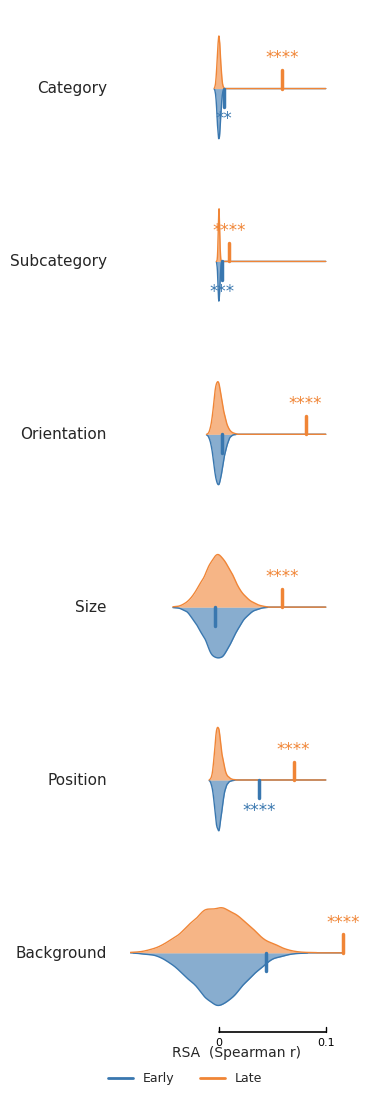

In [3]:
# -------------------------------------------------------------------
# Plotting Script
# -------------------------------------------------------------------

print("Plotting Script start")

from scipy.stats import gaussian_kde
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D

# ───────── config ─────────
PALETTE = {
    "Early": (0.2235, 0.4667, 0.6863),   # blue
    "Late":  (0.9412, 0.5216, 0.2118)    # orange
}
WANT = [
    ("Category",    "category_obs",    "category_perm"),
    ("Subcategory", "subcategory_obs", "subcategory_perm"),
    ("Orientation", "face_orient_obs", "face_orient_perm"),
    ("Size",        "face_size_obs",   "face_size_perm"),
    ("Position",    "face_pos_obs",    "face_pos_perm"),
    ("Background",  "inpaint_obs",     "inpaint_perm"),
]
sns.set_style("white")

def q_to_stars(q):
    return "****" if q < 1e-4 else "***" if q < 1e-3 else "**" if q < 1e-2 else "*" if q < .05 else ""

# ───────── helper to draw ONE panel ─────────
def plot_rotated_density_panel(ax, title_text, obs_rsa, perm_rsa,
                               p_fdr_early, p_fdr_late, is_last):
    """Rotated violin-style density: negative y = Early, positive y = Late."""
    perm_early, perm_late = perm_rsa[:, 0], perm_rsa[:, 1]

    # KDE grid restricted to dense region **AND** forced to include observed values & baseline end-points
    comb = np.concatenate([perm_early, perm_late])
    lo, hi = np.percentile(comb, [.1, 99.9])
    pad = (hi - lo) * 0.02
    xmin = min(lo - pad, obs_rsa.min(), 0)          # include 0 for baseline
    xmax = max(hi + pad, obs_rsa.max(), 0.10)       # include 0.10 for baseline
    x_grid = np.linspace(xmin, xmax, 400)

    dens_e = gaussian_kde(perm_early)(x_grid)
    dens_l = gaussian_kde(perm_late )(x_grid)

    # zero tiny tails
    dens_e[dens_e < 0.005 * dens_e.max()] = 0
    dens_l[dens_l < 0.005 * dens_l.max()] = 0
    max_d = max(dens_e.max(), dens_l.max(), 1e-8)

    # -- densities
    ax.fill_between(x_grid, -dens_e, 0,  color=PALETTE["Early"], alpha=0.6, lw=0)
    ax.plot(x_grid, -dens_e,              color=PALETTE["Early"], lw=1)
    ax.fill_between(x_grid, 0,  dens_l,   color=PALETTE["Late"],  alpha=0.6, lw=0)
    ax.plot(x_grid,  dens_l,              color=PALETTE["Late"],  lw=1)

    # observed vertical bars (never clipped now)
    bar_len = 0.35 * max_d
    ax.plot([obs_rsa[0]]*2, [0, -bar_len], color=PALETTE["Early"], lw=2.5, zorder=3, clip_on=False)
    ax.plot([obs_rsa[1]]*2, [0,  bar_len], color=PALETTE["Late"],  lw=2.5, zorder=3, clip_on=False)
    # significance stars
    star_pad = 0.06 * max_d             # 6 % of full density height

    # Plot star for Early
    s_early = q_to_stars(p_fdr_early)
    if s_early:
        y_bar_end_early = -bar_len
        y_star_early    = y_bar_end_early - star_pad
        ax.text(obs_rsa[0], y_star_early, s_early, ha='center',
                va='top', fontsize=12, color=PALETTE["Early"], zorder=5)

    # Plot star for Late
    s_late = q_to_stars(p_fdr_late)
    if s_late:
        y_bar_end_late = bar_len
        y_star_late    = y_bar_end_late + star_pad
        ax.text(obs_rsa[1], y_star_late, s_late, ha='center',
                va='bottom', fontsize=12, color=PALETTE["Late"], zorder=5)


    # panel label on the left
    ax.set_ylabel(title_text, fontsize=11, rotation=0,
                  ha='right', va='center')
    ax.yaxis.set_label_coords(-0.11, 0.5)

    # tidy appearance
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-max_d*1.5, max_d*1.5)
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

    # baseline + custom ticks ONLY on last subplot
    if is_last:
        y0 = ax.get_ylim()[0]
        tick_len = 0.25 * bar_len
        ax.plot([0, 0.10], [y0, y0], color='black', lw=1.2, clip_on=False, zorder=10)
        for xt in [0, 0.10]:
            ax.plot([xt, xt], [y0, y0 + tick_len], color='black', lw=1, clip_on=False, zorder=10)
            ax.text(xt, y0 - tick_len*1.2, f"{xt:0.2g}", ha='center', va='top',
                    fontsize=8, color='black', zorder=10)

        ax.set_xlabel("RSA  (Spearman r)", labelpad=10)
# ------------------------------------------------------------------


# ───────── load & prepare data ─────────
DATA_FNAME = os.path.join("Statistics", "rsa_results.npz")
dat = np.load(DATA_FNAME, allow_pickle=True)

valid = []
for title, ok, pk in WANT:
    if ok in dat and pk in dat:
        obs, perm = dat[ok], dat[pk]
        if obs.shape == (2,) and perm.ndim == 2 and perm.shape[1] == 2:
            valid.append((title, obs, perm))

if not valid:
    raise RuntimeError("No valid RSA metrics in file.")

# raw p-values then FDR
raw_ps_early = [(perm[:,0] >= obs[0]).mean() for _,obs,perm in valid]
raw_ps_late  = [(perm[:,1] >= obs[1]).mean() for _,obs,perm in valid]

_, qvals_early = fdrcorrection(raw_ps_early, alpha=0.05, method='indep')
_, qvals_late  = fdrcorrection(raw_ps_late, alpha=0.05, method='indep')

# ───────── figure ─────────
fig_h = max(2.5, 1.8 * len(valid))
fig, axes = plt.subplots(len(valid), 1, figsize=(3.8, fig_h),
                         tight_layout=True, sharex=True)
if len(valid) == 1:
    axes = [axes]

for i, (ax, (title, obs, perm)) in enumerate(zip(axes, valid)):
    plot_rotated_density_panel(ax, title, obs, perm,
                               p_fdr_early=qvals_early[i],
                               p_fdr_late=qvals_late[i],
                               is_last=(i == len(axes)-1))

# global legend (below all panels, outside plot)
legend_elems = [Line2D([0],[0], color=PALETTE['Early'], lw=2, label='Early'),
                Line2D([0],[0], color=PALETTE['Late'],  lw=2, label='Late')]
fig.legend(handles=legend_elems,
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=2, frameon=False, fontsize=9)

# save
os.makedirs("Figures", exist_ok=True)
out_path = Path("Figures") / "all_rsa_panels_rotated_shared_x.svg"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"saved → {out_path}")